# Decision Tree on Yearly Aggregates
<a id='top'></a>

<a href=#readdata>Read Data</a>  

<a href=#features>Feature Selection</a>

<a href=#dt>Decision Tree</a>

<a href=#inspectfeatures>Inspect Features</a>

<a href=#dummy>One Hot Encode</a>

<a href=#balancedata>Balance Data</a>

<a href=#dt_rebalance>Decision Tree on Re-Balance Data</a>

<a href=#plot>Plot ROC Curve</a>

<a href=#bottom>Bottom</a>


In [87]:
# Ignore 'dask' warning
import pandas as pd
import gcsfs
from google.cloud import storage
from pandas import DataFrame
from IPython.display import HTML
from google.cloud.storage import Blob
import datalab.storage as gcs_datalab
from datetime import date
import numpy as np

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.utils import resample
from sklearn import preprocessing
from scipy.stats import sem


from matplotlib import pyplot
import seaborn as sns
from scipy import stats

<a id='readdata'></a>
# Read Yearly Aggregated Data 
<a href=#top>Top</a>

In [2]:
# Setting up constants. All required
project = 'graydon-moving-indicator'
bucket_name = 'graydon-data'

In [3]:
# Initializing bucket
fs = gcsfs.GCSFileSystem(project='graydon-moving-indicator')
gcs = storage.Client()
bucket = gcs.get_bucket(bucket_name)

In [4]:
# Setting up constants. All required
project = 'graydon-moving-indicator'
bucket_name = 'graydon-data'

# Initializing bucket
fs = gcsfs.GCSFileSystem(project='graydon-moving-indicator')
gcs = storage.Client()
bucket = gcs.get_bucket(bucket_name)


# Setting up dictionary of column types
dtype={ 'id_company'  :np.float64,
        'id_branch'    :np.int64, 
        'code_sbi_2'         : np.float64, 
        'code_sbi_1'          :object, 
        'has_relocated':bool,
        'has_relocated_next_year ' : bool,
        'qty_address_mutations_total' :np.float64,
        #'has_name_change'  :bool,
        'ratio_operating_result_consolidated_operating_result': np.float64,
        'ratio_revenue_consolidated_revenue': np.float64,
        'qty_green_flags'   :np.float64,
        'qty_orange_flags'   :np.float64,
        'qty_red_flags'   :np.float64,
        'A'   :np.float64,
        'AA'   :np.float64,
        'AAA'   :np.float64,
        'B'   :np.float64,
        'BB'   :np.float64,
        'BBB'   :np.float64,
        'C'   :np.float64,
        'CC'   :np.float64,
        'CCC'   :np.float64,
        'D'   :np.float64,
        'NR'   :np.float64,
        'company_age'   :np.float64,
        'years_since_last_amt_consolidated_operating_result'   :np.float64,
        'years_since_last_amt_consolidated_revenue'   :np.float64,
        'years_since_last_amt_operating_result'   :np.float64,
        'years_since_last_qty_employees'   :np.float64,
        'years_since_last_amt_revenue'   :np.float64,
        'delta_qty_employees'   :np.float64,
        'delta_qty_issued_credit_reports'   :np.float64,
        'delta_score_payment_assessment'   :np.float64,
        'delta_score_payment_assessment'   :np.float64,
        'code_legal_form_has_changed ' : bool,
        'is_discontinued_any ' : bool,
        'has_financial_calamity ' : bool,
        'mean_amt_consolidated_operating_result'   :np.float64,
        'mean_amt_consolidated_revenue'   :np.float64,
        'mean_amt_operating_result'   :np.float64,
        'mean_amt_revenue'   :np.float64,
        'mean_qty_employees'   :np.float64,
        'mean_qty_issued_credit_reports'   :np.float64,
        'mean_score_payment_assessment'   :np.float64,
        'mean_score_pd'   :np.float64,
        'qty_address_mutations_year'   :np.float64,
        'qty_started_names_year'   :np.float64,
        'qty_stopped_names_year'   :np.float64,
        'qty_board_changes_year'   :np.float64,
        'variance_qty_issued_credit_reports'   :np.float64,
        'variance_score_payment_assessment'   :np.float64,
        'variance_score_pd'   :np.float64
      }


# Setting up dictionary of column types
parse_dates= ['date_month', 'date_relocation_last', 'date_relocation_penultimate']

def read_one_year_from_bucket_merged_csv(year, dir_prefix = ''):
    """ Reads a whole year of data from the already merged files """
    full_year_df = pd.DataFrame()
    print('Starting with year: ', year)
    print(dir_prefix)
    blob_list = list(bucket.list_blobs(prefix=dir_prefix))    
    for blob in blob_list:  
        print("blob", blob.name)
        if year in blob.name:
            print('Processing file: ', blob.name)
            with fs.open('graydon-data/' + blob.name) as f:
                full_year_df = pd.read_csv(f, sep=',', index_col=0, dtype=dtype, parse_dates=parse_dates)   
        print('The number of rows so far is: ', full_year_df.shape[0])
    return full_year_df



In [5]:
data_df = read_one_year_from_bucket_merged_csv(
    dir_prefix= 'including_scores/merged_per_year/aggregated'
                                                   , year = '2017')

Starting with year:  2017
including_scores/merged_per_year/aggregated
blob including_scores/merged_per_year/aggregated/
The number of rows so far is:  0
blob including_scores/merged_per_year/aggregated/2017_merged_cleaned.csv
Processing file:  including_scores/merged_per_year/aggregated/2017_merged_cleaned.csv


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


The number of rows so far is:  1965800


In [6]:
sum(data_df.has_relocated_next_year.isna())

73876

In [7]:
data_df[data_df.has_relocated_next_year.notna()].shape

(1891924, 54)

In [8]:
data_df.columns

Index(['id_branch', 'date_month', 'id_company', 'code_sbi_2', 'code_sbi_1',
       'qty_address_mutations_total', 'has_relocated', 'has_name_change',
       'date_relocation_last', 'date_relocation_penultimate',
       'ratio_operating_result_consolidated_operating_result',
       'ratio_revenue_consolidated_revenue', 'qty_green_flags',
       'qty_orange_flags', 'qty_red_flags', 'A', 'AA', 'AAA', 'B', 'BB', 'BBB',
       'C', 'CC', 'CCC', 'D', 'NR', 'company_age',
       'years_since_last_amt_consolidated_operating_result',
       'years_since_last_amt_consolidated_revenue',
       'years_since_last_amt_operating_result',
       'years_since_last_qty_employees', 'years_since_last_amt_revenue',
       'delta_qty_employees', 'delta_qty_issued_credit_reports',
       'delta_score_payment_assessment', 'code_legal_form_has_changed',
       'is_discontinued_any', 'has_financial_calamity',
       'mean_amt_consolidated_operating_result',
       'mean_amt_consolidated_revenue', 'mean_amt_oper

In [9]:
data_df = data_df[data_df.has_relocated_next_year.notna()]

In [10]:
HTML(DataFrame(data_df).head(10).to_html())

,id_branch,date_month,id_company,code_sbi_2,code_sbi_1,qty_address_mutations_total,has_relocated,has_name_change,date_relocation_last,date_relocation_penultimate,ratio_operating_result_consolidated_operating_result,ratio_revenue_consolidated_revenue,qty_green_flags,qty_orange_flags,qty_red_flags,A,AA,AAA,B,BB,BBB,C,CC,CCC,D,NR,company_age,years_since_last_amt_consolidated_operating_result,years_since_last_amt_consolidated_revenue,years_since_last_amt_operating_result,years_since_last_qty_employees,years_since_last_amt_revenue,delta_qty_employees,delta_qty_issued_credit_reports,delta_score_payment_assessment,code_legal_form_has_changed,is_discontinued_any,has_financial_calamity,mean_amt_consolidated_operating_result,mean_amt_consolidated_revenue,mean_amt_operating_result,mean_amt_revenue,mean_qty_employees,mean_qty_issued_credit_reports,mean_score_payment_assessment,mean_score_pd,qty_address_mutations_year,qty_started_names_year,qty_stopped_names_year,qty_board_changes_year,variance_qty_issued_credit_reports,variance_score_payment_assessment,variance_score_pd,has_relocated_next_year
0,0,2017-01-01,902120824.0,0.0,NaN,0.0,False,False,NaT,NaT,NaN,NaN,2.0,0.0,4906.0,119.0,0.0,0.0,12.0,0.0,73.0,0.0,0.0,0.0,0.0,4704.0,38.0,NaN,NaN,NaN,4.0,NaN,0.0,0.0,0.0,False,False,False,0.0,0.0,0.000000e+00,0.0,0.000407,0.000815,0.01141,-0.002178,0.0,0.0,0.0,0.0,0.000814,56.0,-10.691,False
1,35,2017-01-01,12.0,64.0,NaN,0.0,False,False,2017-08-03,NaT,NaN,NaN,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,94.0,NaN,NaN,NaN,1.0,NaN,0.0,0.0,0.0,False,False,False,0.0,0.0,0.000000e+00,0.0,5.000000,0.250000,28.00000,-5.078833,1.0,0.0,0.0,0.0,0.204545,336.0,-60.946,False
2,43,2017-01-01,14.0,64.0,NaN,0.0,False,False,NaT,NaT,NaN,NaN,12.0,0.0,0.0,5.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,197.0,NaN,NaN,NaN,1.0,NaN,0.0,0.0,0.0,False,False,False,0.0,0.0,0.000000e+00,0.0,6.000000,0.166667,20.00000,-4.996583,0.0,0.0,0.0,0.0,0.151515,240.0,-59.959,False
3,51,2017-01-01,17.0,64.0,NaN,0.0,False,False,2002-02-07,NaT,NaN,NaN,12.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,0.0,0.0,False,False,False,0.0,0.0,0.000000e+00,0.0,1.000000,0.000000,20.00000,-5.014500,0.0,0.0,0.0,0.0,0.000000,240.0,-60.174,False
4,94,2017-01-01,23.0,46.0,NaN,0.0,False,False,NaT,NaT,NaN,NaN,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,103.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,False,True,False,0.0,0.0,0.000000e+00,0.0,0.000000,0.000000,29.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,348.0,0.000,False
5,140,2017-01-01,47.0,70.0,NaN,0.0,False,False,NaT,NaT,NaN,NaN,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,156.0,NaN,NaN,NaN,11.0,NaN,0.0,0.0,0.0,False,False,False,0.0,0.0,0.000000e+00,0.0,1.000000,0.000000,20.00000,-5.121000,0.0,0.0,0.0,0.0,0.000000,240.0,-61.452,False
6,175,2017-01-01,53.0,47.0,NaN,0.0,False,False,NaT,NaT,NaN,NaN,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,NaN,NaN,NaN,NaN,11.0,NaN,0.0,0.0,0.0,False,False,False,0.0,0.0,0.000000e+00,0.0,3.000000,0.000000,20.00000,-5.522000,0.0,0.0,0.0,0.0,0.000000,240.0,-66.264,False
7,183,2017-01-01,54.0,64.0,NaN,0.0,False,False,NaT,NaT,NaN,NaN,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,39.0,NaN,NaN,NaN,1.0,NaN,0.0,0.0,0.0,False,False,False,0.0,0.0,0.000000e+00,0.0,1.000000,0.000000,20.00000,-4.997417,0.0,0.0,0.0,0.0,0.000000,240.0,-59.969,False
8,248,2017-01-01,63.0,68.0,NaN,0.0,False,False,NaT,NaT,NaN,NaN,12.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,1.0,0.0,0.0,99.0,NaN,NaN,NaN,1.0,NaN,0.0,0.0,0.0,False,False,False,0.0,0.0,0.000000e+00,0.0,4.000000,0.000000,20.00000,-5.045000,0.0,0.0,0.0,2.0,0.000000,240.0,-60.540,False
9,272,2017-01-01,68.0,13.0,NaN,0.0,False,False,2006-01-05,NaT,inf,NaN,0.0,3.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,57.0,NaN,NaN,NaN,1.0,NaN,0.0,-1.0,0.0,False,False,False,0.0,0.0,1.607146e-319,0.0,1.000000,0.250000,21.00000,-4.726750,0.0,0.0,0.0,0.0,0.204545,252.0,-56.721,False


In [10]:
data_df[data_df.has_relocated_next_year.notna()].shape

(1891924, 54)

In [11]:
data_df.shape

(1891924, 54)

<a id='features'></a>
# Feature Selection:

<a href=#top>Top</a>

In [102]:
features_to_exclude = ( 'id_branch', 
                       'date_month', 
                       'id_company',
                      'ratio_revenue_consolidated_revenue',
                       'code_sbi_1',
                       'date_relocation_penultimate',
                       'years_since_last_amt_consolidated_operating_result',
                       'years_since_last_amt_consolidated_revenue', 
                       'years_since_last_amt_operating_result', 
                       'years_since_last_qty_employees', 
                       'years_since_last_amt_revenue',
#                       'variance_qty_issued_credit_reports',
#                       'company_age',
                       'ratio_operating_result_consolidated_operating_result',
                       'has_relocated', 
                       'date_relocation_last',
                       'has_relocated_next_year',
                      )

features_in_model = [feature for feature in data_df.columns.tolist() 
                     if feature not in features_to_exclude]



In [40]:
features_in_model

['code_sbi_2',
 'qty_address_mutations_total',
 'has_name_change',
 'qty_green_flags',
 'qty_orange_flags',
 'qty_red_flags',
 'A',
 'AA',
 'AAA',
 'B',
 'BB',
 'BBB',
 'C',
 'CC',
 'CCC',
 'D',
 'NR',
 'company_age',
 'delta_qty_employees',
 'delta_qty_issued_credit_reports',
 'delta_score_payment_assessment',
 'code_legal_form_has_changed',
 'is_discontinued_any',
 'has_financial_calamity',
 'mean_amt_consolidated_operating_result',
 'mean_amt_consolidated_revenue',
 'mean_amt_operating_result',
 'mean_amt_revenue',
 'mean_qty_employees',
 'mean_qty_issued_credit_reports',
 'mean_score_payment_assessment',
 'mean_score_pd',
 'qty_address_mutations_year',
 'qty_started_names_year',
 'qty_stopped_names_year',
 'qty_board_changes_year',
 'variance_score_payment_assessment',
 'variance_score_pd',
 'has_relocated_next_year']

In [103]:
data_df.isnull().values.any()

True

In [104]:
data_to_model = data_df[features_in_model + ['has_relocated_next_year']]

In [105]:
data_to_model.shape

(1891924, 40)

## Check for NAs

Drop rows with NA:

For other options: https://machinelearningmastery.com/handle-missing-data-python/

In [106]:
data_to_model.isnull().values.any()

True

In [107]:
print(data_to_model.isnull().sum())

code_sbi_2                                    0
qty_address_mutations_total                   0
has_name_change                               0
qty_green_flags                               0
qty_orange_flags                              0
qty_red_flags                                 0
A                                             0
AA                                            0
AAA                                           0
B                                             0
BB                                            0
BBB                                           0
C                                             0
CC                                            0
CCC                                           0
D                                             0
NR                                            0
company_age                               29233
delta_qty_employees                           0
delta_qty_issued_credit_reports               0
delta_score_payment_assessment          

Drop rows with NA:

In [108]:
data_to_model.dropna(inplace=True)

# summarize the number of rows and columns in the dataset
print(data_to_model.shape)

(1853173, 40)


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [109]:
data_to_model.isnull().values.any()

False

<a id='dt'></a>
# Decision Tree:

<a href=#top>Top</a>

### Create Test/Train sets

In [112]:
x_train, x_test, y_train, y_test = train_test_split(data_to_model[features_in_model], data_to_model.has_relocated_next_year, 
                                                    test_size=0.30, random_state=0)
y_train=y_train.astype('int')
y_test=y_test.astype('int')

In [111]:
y_train.value_counts()

0    1321833
1      68046
Name: has_relocated_next_year, dtype: int64

In [62]:
clf0 = tree.DecisionTreeClassifier()
clf0.fit(x_train, y_train)  


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [72]:
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print ("Confusion matrix")
        print (metrics.confusion_matrix(y,y_pred),"\n")
        
measure_performance(x_train,y_train,clf0, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.986 



In [91]:
parameters = {'max_depth':range(3,20), 'min_samples_split':range(5, 20)}
clf00 = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf00.fit(X=x_train, y=y_train)
clf0 = clf00.best_estimator_
print (clf00.best_score_, clf00.best_params_)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.9518717036884331 {'max_depth': 8, 'min_samples_split': 5}


In [92]:
measure_performance(x_train,y_train,clf0, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.952 



In [93]:
clf0

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [94]:
y_pred=clf0.predict(x_test)

In [95]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1327797,     636],
       [  66478,    2108]])

In [65]:
print('Accuracy of Decision Tree classifier on test set: {:.4f}'.format(clf0.score(x_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.9177


In [96]:
y_test.value_counts() / y_test.shape[0]

0    0.950905
1    0.049095
Name: has_relocated_next_year, dtype: float64

In [97]:
score=metrics.accuracy_score(y_test, y_pred)

# Get probabilities
y_probs = clf0.predict_proba(x_test)

# keep probabilities for the positive outcome only
y_probs = y_probs[:, 1]

auc = metrics.roc_auc_score(y_test, y_probs)

kappa = metrics.cohen_kappa_score(y_test, y_pred)
cr=metrics.classification_report(y_test, y_pred)

In [101]:
score, auc, kappa

(0.9519591358456828, 0.6802213462938421, 0.05553810263678016)

In [99]:
print(cr)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98   1328433
           1       0.77      0.03      0.06     68586

   micro avg       0.95      0.95      0.95   1397019
   macro avg       0.86      0.52      0.52   1397019
weighted avg       0.94      0.95      0.93   1397019



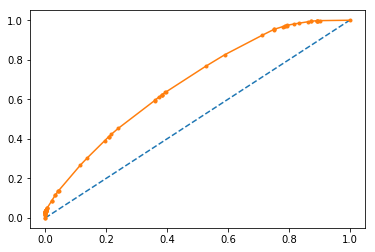

In [100]:
fpr0, tpr0, thresholds0 = metrics.roc_curve(y_test, y_probs)

# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr0, tpr0, marker='.')
# show the plot
pyplot.show()

<a id='balancedata'></a>
## Balance Data:

<a href=#top>Top</a>

In [113]:
# Choose desired class breakdown
fraction_majority = 0.50

In [114]:
num_minority = data_df[data_df['has_relocated_next_year']==True].shape[0]

num_majority = fraction_majority * num_minority / (1 - fraction_majority)

num_minority, int(num_majority), num_majority, num_majority/(num_majority + num_minority)

(91577, 91577, 91577.0, 0.5)

In [115]:
# Separate majority and minority classes
df_majority = data_df[data_df.has_relocated_next_year==False]
df_minority = data_df[data_df.has_relocated_next_year==True]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=int(num_majority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.has_relocated_next_year.value_counts()

True     91577
False    91577
Name: has_relocated_next_year, dtype: int64

In [116]:
df_downsampled.has_relocated_next_year.value_counts()/df_downsampled.shape[0]

True     0.5
False    0.5
Name: has_relocated_next_year, dtype: float64

In [125]:
df_downsampled.shape

(183154, 54)

## Remove NaNs from Balanced Dataset:

In [123]:
data_to_model = df_downsampled[features_in_model + ['has_relocated_next_year']]

In [126]:
data_to_model.shape

(183154, 40)

## Check for NAs

Drop rows with NA:

For other options: https://machinelearningmastery.com/handle-missing-data-python/

In [127]:
data_to_model.isnull().values.any()

True

In [128]:
print(data_to_model.isnull().sum())

code_sbi_2                                   0
qty_address_mutations_total                  0
has_name_change                              0
qty_green_flags                              0
qty_orange_flags                             0
qty_red_flags                                0
A                                            0
AA                                           0
AAA                                          0
B                                            0
BB                                           0
BBB                                          0
C                                            0
CC                                           0
CCC                                          0
D                                            0
NR                                           0
company_age                               1503
delta_qty_employees                          0
delta_qty_issued_credit_reports              0
delta_score_payment_assessment               0
code_legal_fo

Drop rows with NA:

In [129]:
data_to_model.dropna(inplace=True)

# summarize the number of rows and columns in the dataset
print(data_to_model.shape)

(180434, 40)


/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [130]:
data_to_model.isnull().values.any()

False

<a id='dt_rebalance'></a>

# Decision Tree on Re-balanced data

<a href=#top>Top</a>

In [131]:
x_re_train, x_re_test, y_re_train, y_re_test = train_test_split(data_to_model[features_in_model], 
                                                                data_to_model.has_relocated_next_year, 
                                                    test_size=0.25, random_state=0)

y_re_train=y_re_train.astype('int')
y_re_test=y_re_test.astype('int')

In [132]:
x_train.shape

(1297221, 39)

In [133]:
x_re_train.shape

(135325, 39)

In [136]:
clf = tree.DecisionTreeClassifier()

clf.fit(x_re_train, y_re_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [137]:
# Default DT accuracy:
measure_performance(x_re_train,y_re_train,clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.930 



In [145]:
parameters = {'max_depth':range(3,20), 'min_samples_split':range(5, 20)}
clfB = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clfB.fit(X=x_re_train, y=y_re_train)
clf = clfB.best_estimator_
print (clfB.best_score_, clfB.best_params_)

/home/mrodriguezlara/graydon/graydon-moving/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.6284056900055423 {'max_depth': 13, 'min_samples_split': 16}


In [146]:
# Grid searched DT accuracy:
measure_performance(x_re_train,y_re_train, clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.648 



In [147]:
y_re_pred=clf.predict(x_re_test)

In [148]:
cnf_matrix = metrics.confusion_matrix(y_re_test, y_re_pred)
cnf_matrix

array([[12170, 10162],
       [ 6439, 16338]])

In [149]:
score=metrics.accuracy_score(y_re_test, y_re_pred)

# Get probabilities
y_re_probs = clf.predict_proba(x_re_test)

# keep probabilities for the positive outcome only
y_re_probs = y_re_probs[:, 1]

auc = metrics.roc_auc_score(y_re_test, y_re_probs)

kappa = metrics.cohen_kappa_score(y_re_test, y_re_pred)
cr=metrics.classification_report(y_re_test, y_re_pred)

In [150]:
score, auc, kappa

(0.6319803143496863, 0.6883272914893022, 0.2626882487667249)

In [151]:
print(cr)

              precision    recall  f1-score   support

           0       0.65      0.54      0.59     22332
           1       0.62      0.72      0.66     22777

   micro avg       0.63      0.63      0.63     45109
   macro avg       0.64      0.63      0.63     45109
weighted avg       0.64      0.63      0.63     45109



<a id='plot'></a>
# Plot

<a href=#top>Top</a>


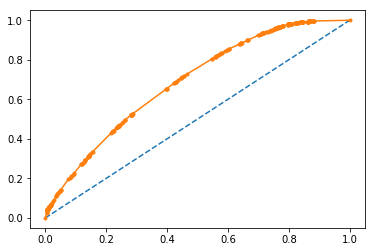

In [152]:
fpr, tpr, thresholds = metrics.roc_curve(y_re_test, y_re_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [154]:
tree.export_graphviz(clf, out_file='tree.dot')

In [155]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus


ImportError: No module named 'pydotplus'

In [ ]:
dot_data = StringIO()

export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
